## Imports

In [1]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Utils

In [2]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None):
    n = source.shape[0]
    idx = random.sample(range(n), nrow * ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(prediction[idx[i], from_:to_], c='r')
            axs[r,c].plot(source[idx[i], from_:to_], c='b')

            i += 1
    fig.tight_layout()
    plt.show()

In [3]:
def plot_shape_function(d, F1, F2, nrow=5, ncol=5):
    n = F1.shape[1]
    idx = random.sample(range(n), nrow * ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            if F2 is not None:
                axs[r,c].scatter(d, F1[:, idx[i]], c='b')
                axs[r,c].scatter(d, F2[:, idx[i]], c='r')
            else:
                axs[r,c].scatter(d, F1[:, idx[i]])
            i += 1
    fig.tight_layout()
    plt.show()

In [5]:
# Colors
# size = out[2].shape[1]
# colors = list(mcolors.CSS4_COLORS.keys())
# indices = random.choices(range(len(colors)), k=size)

In [4]:
def scale(X, max_, min_):
    X_std = (X - X.min(axis=1).reshape(-1,1)) / ((X.max(axis=1) - X.min(axis=1)).reshape(-1,1))
    X_std = X_std * (max_ - min_) + min_
    return X_std

## Forecasting

In [6]:
sim = load_pickle('output/sim.pickle')

In [7]:
sim[2] = sim[2].detach().numpy()
sim[0].shape, sim[1].shape, sim[2].shape

((30, 500), (30, 500), (900, 1))

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(sim[1][10, :], c='r')
plt.plot(sim[0][10, :], c='b')

plt.show()

In [ ]:
plot_forecast(sim[0], sim[1], 6, 5, 0, 500)

## Shape Function

In [9]:
_, d, _ = load_pickle('data/sample.pickle')

In [10]:
# d_norm = scale(d.reshape(1,-1), 1, 0).reshape(-1)
d_norm = d

In [11]:
F = np.log(d_norm+1)

In [12]:
d_norm.shape, sim[2].shape, F.shape

((900,), (900, 1), (900,))

In [ ]:
l = 0
plt.figure(figsize=(20,10))
plt.scatter(d_norm[:], F[:, ], c='b', label='estimated')
plt.scatter(d_norm[:], sim[2][:, l], c='r', label='actual')
plt.legend()
plt.show()

In [ ]:
plot_shape_function(d_norm, sim[2], None, 5, 5)

## Baselines Comparison

In [5]:
data = np.load('data/data.npy')
ids, d, _ = load_pickle('data/sample.pickle')

In [6]:
N, T = data.shape
N, T

(30, 7320)

In [7]:
data = scale(data, 10, 0)

In [8]:
x_offsets = np.sort(np.concatenate((np.arange(1-20, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+20, 1))

In [9]:
x_ids, y_ids = [], []
# t is the index of the last observation.
min_t = abs(min(x_offsets))
max_t = abs(T - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [74]:
def aggregate(v, n=7320, h=20, loc=30):
    out = [np.zeros((1, loc)) for _ in range(n)]
    cnt = [np.ones((1, loc)) for _ in range(h)] + [np.zeros((1, loc)) for _ in range(n-h)]
    L = len(y_ids)
    for l in range(L):
        i = y_ids[l] 
        out[i] += v[l, :]
        cnt[i] += 1

    outs = np.concatenate(out)
    cnts = np.concatenate(cnt)
    return (outs/cnts).transpose()

In [11]:
def load_outputs(path):
    data = np.load(path)
    print(data['input'].shape, data['prediction'].shape, data['truth'].shape)
    return data['input'], data['prediction'], data['truth']

### 1. DCRNN

In [67]:
input, pred, label = load_outputs('DC-RNN/data/STVAR/dcrnn_full_predictions.npz')

(20, 7320, 30) (20, 7320, 30) (20, 7320, 30)


In [69]:
pred, label = pred.swapaxes(0,1), label.swapaxes(0,1)

In [75]:
predictions = aggregate(pred.reshape(-1, 30))
labels = aggregate(label.reshape(-1, 30))

In [73]:
predictions.shape, labels.shape

(30, 7320)

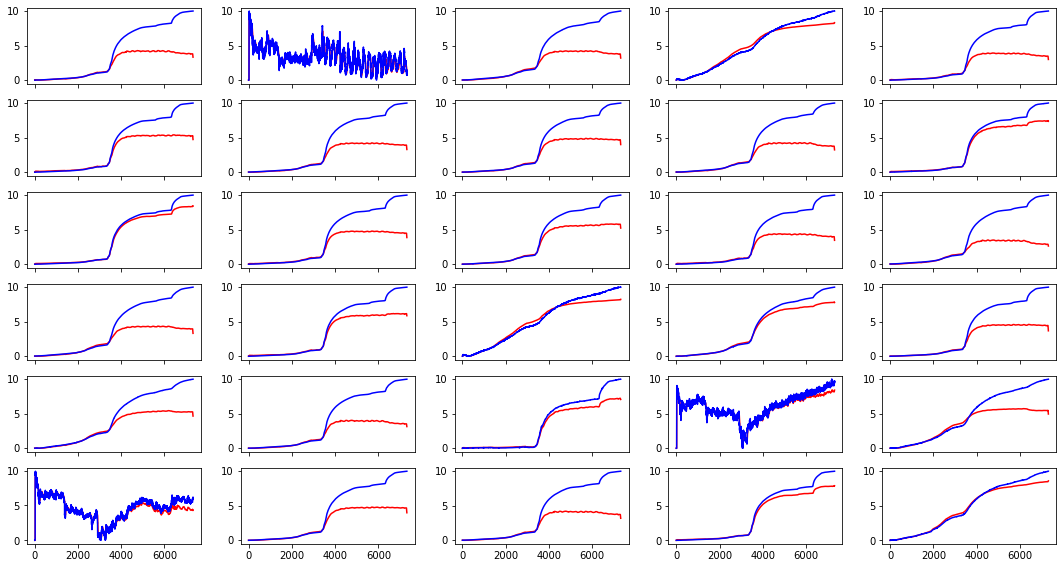

In [77]:
plot_forecast(labels, predictions, 6, 5, 0, 7320)

### 2. FC-GAGA

In [78]:
input, pred, label = load_outputs('FC-GAGA/data/stvar/full_predictions.npz')

(7281, 30, 20, 1) (7281, 30, 20) (7281, 30, 20)


In [79]:
predictions = aggregate(pred.reshape(-1, 30))
labels = aggregate(label.reshape(-1, 30))

In [80]:
predictions.shape, labels.shape

((30, 7320), (30, 7320))

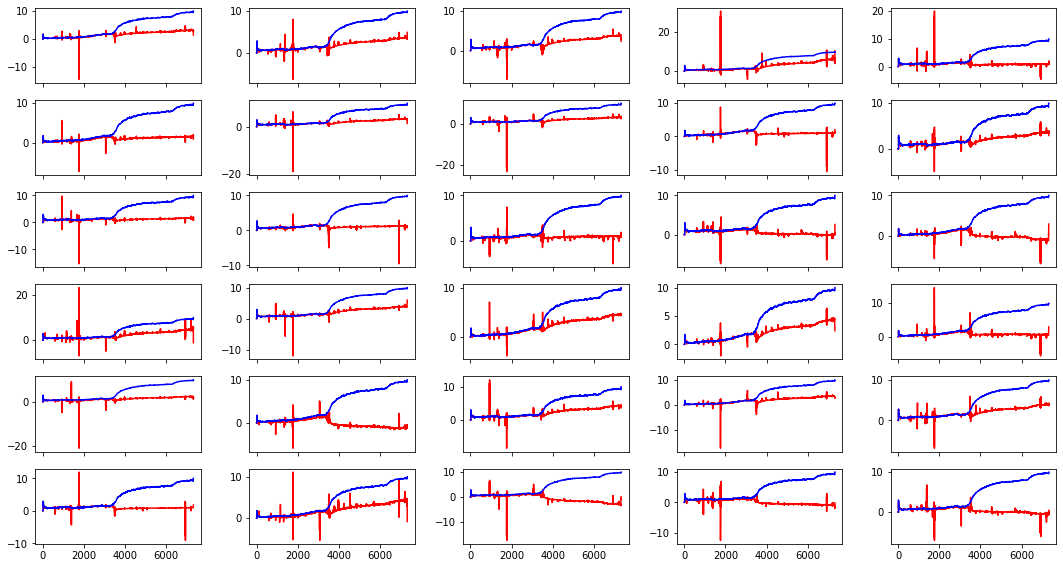

In [81]:
plot_forecast(labels, predictions, 6, 5, 0, 7320)

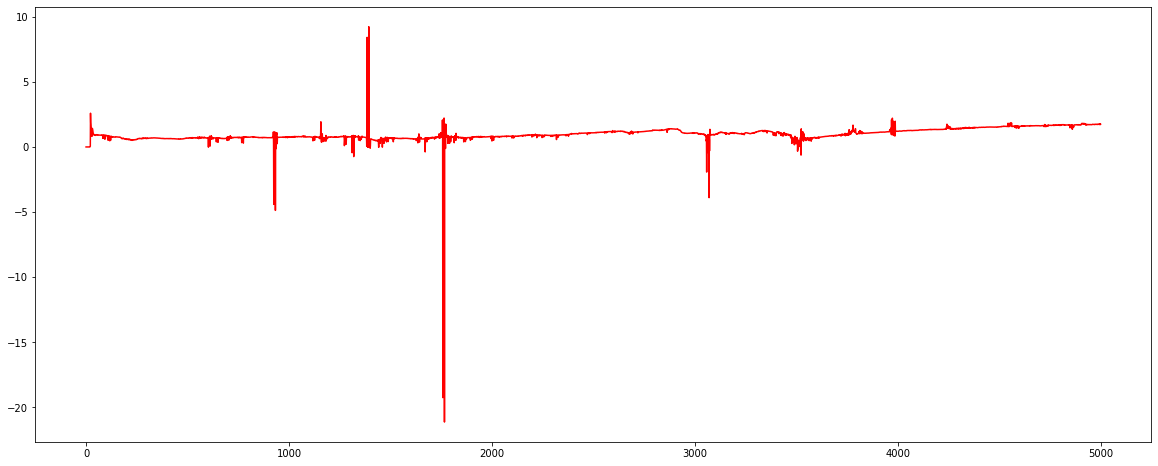

In [87]:
plt.figure(figsize=(20,8))
location_id = 10
from_, to_ = 0, 5000
# plt.plot(labels[location_id, from_:to_] , c='blue')
plt.plot(predictions[location_id, from_:to_], c='red')
# plt.plot(data[20, from_+20:to_+20], c='black')

plt.show()

### Comparison

In [ ]:
plt.figure(figsize=(20,8))
location_id = 20
from_, to_ = 0, 1000
plt.plot(labels[location_id, from_:to_] , c='blue')
# plt.plot(predictions[location_id, from_:to_], c='red')
# plt.plot(data[20, from_+20:to_+20], c='black')

plt.show()